# Library Imports

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score, log_loss
import pandas as pd
import numpy as np
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
import time
from collections import deque
import Adversarial_Model_Module


In [95]:
def model_assessment(predictions, actuals):
    
    #Overall
    overall_accuracy = accuracy_score(actuals, predictions)
    overall_recall = recall_score(actuals, predictions)
    overall_precision = precision_score(actuals, predictions)



    results = pd.DataFrame({
        'Group': ['Overall'],
        'Accuracy': [overall_accuracy],
        'Recall': [overall_recall],
        'Precision': [overall_precision]
    })

    return results

def thresholds_assessment(raw_predictions, actuals, thresholds = list):
    accs =[]
    recalls = []
    precs = []
    for threshold in thresholds:
        new_preds = (raw_predictions >= threshold).astype(int)
        accs.append(accuracy_score(actuals, new_preds))
        recalls.append(recall_score(actuals, new_preds))
        precs.append(precision_score(actuals, new_preds))
    return {'Accuracy': accs, 'Recall': recalls, 'Precision': precs}

def fairness_metrics(input_df, predictions):

    binary_dataset = BinaryLabelDataset(df=input_df, 
                                    label_names=['Coronary heart disease'], 
                                    protected_attribute_names=['Gender'])

    # Create predictions dataset
    pred_df = input_df.drop('Coronary heart disease', axis = 1)
    pred_df['Coronary heart disease'] = predictions
    binary_predictions = BinaryLabelDataset(df=pred_df, 
                                            label_names=['Coronary heart disease'], 
                                            protected_attribute_names=['Gender'])

    # Compute metrics
    metric = ClassificationMetric(binary_dataset, binary_predictions, 
                                unprivileged_groups=[{'Gender': 1}], 
                                privileged_groups=[{'Gender': 0}]) 
    
    demographic_parity_difference = metric.statistical_parity_difference()
    equal_opportunity_difference = metric.equal_opportunity_difference()
    predictive_parity = metric.statistical_parity_difference()
    disparate_impact = metric.disparate_impact()


    #Output Metrics in a Pandas DataFrame
    fairness_table = pd.DataFrame({
        'Metric': ['Demographic Parity Difference', 'Equal Opportunity Difference',
                   'Predictive Parity', 'Disparate Impact'],
        'Value': [demographic_parity_difference, equal_opportunity_difference,
                  predictive_parity, disparate_impact]
    })

    return fairness_table


# Data Load

In [2]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


# Data Processing

# Adversarial Model - Testing

In [25]:
def data_processor(data, batch_size):
    # Define features to normalize (Min-Max)
    normalize_features = ['Weight', 'Body mass index', 'Systolic', 'Diastolic', 'Age',
       'Glycohemoglobin', 'Cholesterol',
       'High-density lipoprotein (HDL)', 'Albumin',
       'Alanine aminotransferase (ALT)', 'Aspartate aminotransferase (AST)',
       'Alkaline phosphatase (ALP)', 'Gamma-glutamyl transferase (GGT)',
       'Glucose', 'Iron', 'Lactate dehydrogenase (LDH)', 'Phosphorus',
       'Bilirubin', 'Protein', 'Triglycerides', 'Uric acid', 'Creatinine',
       'White blood cells', 'Basophils', 'Red blood cells', 'Hemoglobin',
       'Red blood cell width', 'Platelet count', 'Mean volume of platelets',
       'Moderate-work']

    # Categorical Columns
    categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']


    # Data Processing Helper Functions
    minmax_scaler = MinMaxScaler()
    encoder = OneHotEncoder(drop="first")  


    # Binarize Binary Categorical Columns
    data['Gender'] =  data['Gender'].mask(data['Gender'] == 'Male', 1).mask(data['Gender'] == 'Female', 0)
    data['Coronary heart disease'] = data['Coronary heart disease'].mask(data['Coronary heart disease'] == 'Yes', 1).mask(data['Coronary heart disease'] == 'No', 0)

    
    # One-Hot Encoding Before Splitting
    encoder = OneHotEncoder(drop="first", sparse_output=False)
    encoded_data = encoder.fit_transform(data[categorical_cols])

    # Convert to DataFrame
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols), index=data.index)

    # Drop original categorical columns and concatenate one-hot encoded columns
    data = data.drop(columns=categorical_cols).reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)
    data = pd.concat([data, encoded_df], axis=1)

    # Separate Data to Features and Labels
    X = data.drop('Coronary heart disease', axis = 1)
    y = data['Coronary heart disease']

    # Split Data into Train, Validatin, and Test Sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # One-hot Encoding and Normalization of Data
    X_train[normalize_features] = minmax_scaler.fit_transform(X_train[normalize_features])
    X_val[normalize_features] = minmax_scaler.transform(X_val[normalize_features])
    X_test[normalize_features] = minmax_scaler.transform(X_test[normalize_features])



    # Convert Pandas DataFrame to a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((
    X_train.to_numpy().astype(np.float32),  # Features
    X_train['Gender'].to_numpy().reshape(-1, 1).astype(np.int32),  # Sensitive Feature
    y_train.to_numpy().astype(np.int32)  # Ensure labels are integers
    ))

    # Batch Training Set
    buffer_size = len(X_train)  # Ideally, use the dataset size as the buffer
    batched_dataset = dataset.shuffle(buffer_size, seed=42).batch(batch_size)

    return batched_dataset, X_val, y_val, X_test, y_test



In [27]:
training_data, X_val, y_val, X_test, y_test = data_processor(df, 16)

In [32]:
model = Adversarial_Model_Module.AdversarialModel(41,'Gender')

Use /tmp/tmpq5d32oz3 as temporary training directory


/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-06 13:02:46.215160: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2025-02-06 13:02:46.215235: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2025-02-06 13:02:46.215264: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [34]:
model.fit(training_data)


Epoch 1/100
Reading training dataset...
Training dataset read in 0:00:00.088855. Found 27492 examples.
Training model...
Model trained in 0:00:00.091787
Compiling model...
Model compiled.


I0000 00:00:1738875951.734493     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738875951.734525     590 kernel.cc:783] Collect training examples
I0000 00:00:1738875951.734534     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738875951.734584     590 kernel.cc:401] Number of batches: 1720
I0000 00:00:1738875951.734589     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738875951.734845     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 0.0031 - accuracy: 0.9584


2025-02-06 13:06:31.895697: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - loss: -0.0409 - accuracy: 0.9584

Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0499 - accuracy: 0.9584

Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.0438 - accuracy: 0.9584

Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: -0.0562 - accuracy: 0.9584


2025-02-06 13:08:59.748534: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 6/100
Reading training dataset...
Training dataset read in 0:00:00.073870. Found 27492 examples.
Training model...
Model trained in 0:00:00.083615
Compiling model...
Model compiled.


I0000 00:00:1738876142.942919     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738876142.942948     590 kernel.cc:783] Collect training examples
I0000 00:00:1738876142.942958     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738876142.943006     590 kernel.cc:401] Number of batches: 2580
I0000 00:00:1738876142.943013     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738876142.943335     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: -0.0862 - accuracy: 0.9584

Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0740 - accuracy: 0.9584

Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: -0.0869 - accuracy: 0.9584

Epoch 9/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.0336 - accuracy: 0.9584

Epoch 10/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.1054 - accuracy: 0.9584

Epoch 11/100
Reading training dataset...
Training dataset read in 0:00:00.078243. Found 27492 examples.
Training model...
Model trained in 0:00:00.084863
Compiling model...
Model compiled.


I0000 00:00:1738876329.601654     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738876329.601683     590 kernel.cc:783] Collect training examples
I0000 00:00:1738876329.601691     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738876329.601740     590 kernel.cc:401] Number of batches: 3440
I0000 00:00:1738876329.601745     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738876329.601990     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.0078 - accuracy: 0.9584


2025-02-06 13:12:46.553408: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 12/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0924 - accuracy: 0.9584

Epoch 13/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 1.1356 - accuracy: 0.9584

Epoch 14/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 1.3185 - accuracy: 0.9584

Epoch 15/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 1.4969 - accuracy: 0.9584

Epoch 16/100
Reading training dataset...
Training dataset read in 0:00:00.079666. Found 27492 examples.
Training model...
Model trained in 0:00:00.088159
Compiling model...


I0000 00:00:1738876516.806750     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738876516.806778     590 kernel.cc:783] Collect training examples
I0000 00:00:1738876516.806789     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738876516.806838     590 kernel.cc:401] Number of batches: 4300
I0000 00:00:1738876516.806845     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738876516.807186     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

Model compiled.
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.6262 - accuracy: 0.9584

Epoch 17/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.0354 - accuracy: 0.9584

Epoch 18/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0732 - accuracy: 0.9584

Epoch 19/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: -0.0294 - accuracy: 0.9584

Epoch 20/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: -0.1028 - accuracy: 0.9584

Epoch 21/100
Reading training dataset...
Training dataset read in 0:00:00.077038. Found 27492 examples.
Training model...
Model trained in 0:00:00.087235
Compiling model...


I0000 00:00:1738876703.168440     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738876703.168471     590 kernel.cc:783] Collect training examples
I0000 00:00:1738876703.168480     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738876703.168530     590 kernel.cc:401] Number of batches: 5160
I0000 00:00:1738876703.168536     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738876703.168817     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

Model compiled.
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: -0.0825 - accuracy: 0.9584

Epoch 22/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - loss: -0.1034 - accuracy: 0.9584

Epoch 23/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.0957 - accuracy: 0.9584

Epoch 24/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0462 - accuracy: 0.9584

Epoch 25/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0640 - accuracy: 0.9584


2025-02-06 13:21:29.080981: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 26/100
Reading training dataset...
Training dataset read in 0:00:00.076483. Found 27492 examples.
Training model...
Model trained in 0:00:00.088139
Compiling model...
Model compiled.


I0000 00:00:1738876892.278681     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738876892.278713     590 kernel.cc:783] Collect training examples
I0000 00:00:1738876892.278722     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738876892.278772     590 kernel.cc:401] Number of batches: 6020
I0000 00:00:1738876892.278777     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738876892.279032     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: -0.0713 - accuracy: 0.9584

Epoch 27/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - loss: -0.0428 - accuracy: 0.9584

Epoch 28/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0552 - accuracy: 0.9584

Epoch 29/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.9771 - accuracy: 0.9584

Epoch 30/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: 1.5898 - accuracy: 0.9584

Epoch 31/100
Reading training dataset...
Training dataset read in 0:00:00.101171. Found 27492 examples.
Training model...
Model trained in 0:00:00.088202
Compiling model...
Model compiled.


I0000 00:00:1738877081.153505     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738877081.153532     590 kernel.cc:783] Collect training examples
I0000 00:00:1738877081.153541     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738877081.153584     590 kernel.cc:401] Number of batches: 6880
I0000 00:00:1738877081.153590     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738877081.153860     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0072 - accuracy: 0.9584

Epoch 32/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0717 - accuracy: 0.9584

Epoch 33/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0044 - accuracy: 0.9584

Epoch 34/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0680 - accuracy: 0.9584

Epoch 35/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0204 - accuracy: 0.9584

Epoch 36/100
Reading training dataset...
Training dataset read in 0:00:00.075458. Found 27492 examples.
Training model...
Model trained in 0:00:00.088286
Compiling model...
Model compiled.


I0000 00:00:1738877271.499140     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738877271.499171     590 kernel.cc:783] Collect training examples
I0000 00:00:1738877271.499180     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738877271.499228     590 kernel.cc:401] Number of batches: 7740
I0000 00:00:1738877271.499233     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738877271.499543     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: -0.0806 - accuracy: 0.9584

Epoch 37/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0243 - accuracy: 0.9584

Epoch 38/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0673 - accuracy: 0.9584

Epoch 39/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0637 - accuracy: 0.9584

Epoch 40/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 1.8267 - accuracy: 0.9584

Epoch 41/100
Reading training dataset...
Training dataset read in 0:00:00.076921. Found 27492 examples.
Training model...
Model trained in 0:00:00.090754
Compiling model...
Model compiled.


I0000 00:00:1738877459.539763     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738877459.539791     590 kernel.cc:783] Collect training examples
I0000 00:00:1738877459.539799     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738877459.539844     590 kernel.cc:401] Number of batches: 8600
I0000 00:00:1738877459.539850     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738877459.540103     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: -0.1057 - accuracy: 0.9584

Epoch 42/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0160 - accuracy: 0.9584

Epoch 43/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0949 - accuracy: 0.9584

Epoch 44/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0806 - accuracy: 0.9584

Epoch 45/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.5695 - accuracy: 0.9584

Epoch 46/100
Reading training dataset...
Training dataset read in 0:00:00.076954. Found 27492 examples.
Training model...
Model trained in 0:00:00.089372
Compiling model...
Model compiled.


I0000 00:00:1738877647.361846     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738877647.361878     590 kernel.cc:783] Collect training examples
I0000 00:00:1738877647.361887     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738877647.361937     590 kernel.cc:401] Number of batches: 9460
I0000 00:00:1738877647.361942     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738877647.362192     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerized

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.6152 - accuracy: 0.9584

Epoch 47/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0666 - accuracy: 0.9584

Epoch 48/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0679 - accuracy: 0.9584

Epoch 49/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0636 - accuracy: 0.9584

Epoch 50/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0910 - accuracy: 0.9584

Epoch 51/100
Reading training dataset...
Training dataset read in 0:00:00.074767. Found 27492 examples.
Training model...
Model trained in 0:00:00.087422
Compiling model...
Model compiled.


I0000 00:00:1738877835.738571     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738877835.738599     590 kernel.cc:783] Collect training examples
I0000 00:00:1738877835.738608     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738877835.738652     590 kernel.cc:401] Number of batches: 10320
I0000 00:00:1738877835.738657     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738877835.738931     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: -0.0655 - accuracy: 0.9584


2025-02-06 13:37:53.097623: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 52/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0281 - accuracy: 0.9584

Epoch 53/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0779 - accuracy: 0.9584

Epoch 54/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0929 - accuracy: 0.9584

Epoch 55/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0669 - accuracy: 0.9584

Epoch 56/100
Reading training dataset...
Training dataset read in 0:00:00.075829. Found 27492 examples.
Training model...
Model trained in 0:00:00.091336
Compiling model...
Model compiled.


I0000 00:00:1738878024.731650     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738878024.731678     590 kernel.cc:783] Collect training examples
I0000 00:00:1738878024.731688     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738878024.731732     590 kernel.cc:401] Number of batches: 11180
I0000 00:00:1738878024.731737     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738878024.731998     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: -0.0817 - accuracy: 0.9584

Epoch 57/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0882 - accuracy: 0.9584

Epoch 58/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.1055 - accuracy: 0.9584

Epoch 59/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.0481 - accuracy: 0.9584

Epoch 60/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -4.5405e-04 - accuracy: 0.9584

Epoch 61/100
Reading training dataset...
Training dataset read in 0:00:00.074713. Found 27492 examples.
Training model...
Model trained in 0:00:00.092335
Compiling model...
Model compiled.


I0000 00:00:1738878212.623944     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738878212.623974     590 kernel.cc:783] Collect training examples
I0000 00:00:1738878212.623983     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738878212.624033     590 kernel.cc:401] Number of batches: 12040
I0000 00:00:1738878212.624038     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738878212.624283     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.1030 - accuracy: 0.9584

Epoch 62/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0298 - accuracy: 0.9584

Epoch 63/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0753 - accuracy: 0.9584

Epoch 64/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0969 - accuracy: 0.9584

Epoch 65/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 1.1829 - accuracy: 0.9584

Epoch 66/100
Reading training dataset...
Training dataset read in 0:00:00.074861. Found 27492 examples.
Training model...
Model trained in 0:00:00.092454
Compiling model...
Model compiled.


I0000 00:00:1738878401.364033     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738878401.364063     590 kernel.cc:783] Collect training examples
I0000 00:00:1738878401.364072     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738878401.364120     590 kernel.cc:401] Number of batches: 12900
I0000 00:00:1738878401.364126     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738878401.364403     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 1.4508 - accuracy: 0.9584

Epoch 67/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.0098 - accuracy: 0.9584

Epoch 68/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0942 - accuracy: 0.9584

Epoch 69/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 1.8012 - accuracy: 0.9584

Epoch 70/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0754 - accuracy: 0.9584

Epoch 71/100
Reading training dataset...
Training dataset read in 0:00:00.076120. Found 27492 examples.
Training model...
Model trained in 0:00:00.090934
Compiling model...
Model compiled.


I0000 00:00:1738878590.107037     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738878590.107065     590 kernel.cc:783] Collect training examples
I0000 00:00:1738878590.107073     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738878590.107121     590 kernel.cc:401] Number of batches: 13760
I0000 00:00:1738878590.107126     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738878590.107425     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: -0.0772 - accuracy: 0.9584

Epoch 72/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0337 - accuracy: 0.9584

Epoch 73/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.5817 - accuracy: 0.9584

Epoch 74/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0866 - accuracy: 0.9584

Epoch 75/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0655 - accuracy: 0.9584

Epoch 76/100
Reading training dataset...
Training dataset read in 0:00:00.074561. Found 27492 examples.
Training model...
Model trained in 0:00:00.093957
Compiling model...
Model compiled.


I0000 00:00:1738878779.239367     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738878779.239393     590 kernel.cc:783] Collect training examples
I0000 00:00:1738878779.239402     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738878779.239447     590 kernel.cc:401] Number of batches: 14620
I0000 00:00:1738878779.239453     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738878779.239747     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 1.5505 - accuracy: 0.9584

Epoch 77/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0913 - accuracy: 0.9584

Epoch 78/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0929 - accuracy: 0.9584

Epoch 79/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.7167 - accuracy: 0.9584

Epoch 80/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0581 - accuracy: 0.9584

Epoch 81/100
Reading training dataset...
Training dataset read in 0:00:00.075599. Found 27492 examples.
Training model...
Model trained in 0:00:00.093704
Compiling model...
Model compiled.


I0000 00:00:1738878967.275035     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738878967.275062     590 kernel.cc:783] Collect training examples
I0000 00:00:1738878967.275073     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738878967.275121     590 kernel.cc:401] Number of batches: 15480
I0000 00:00:1738878967.275126     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738878967.275648     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: -0.0815 - accuracy: 0.9584

Epoch 82/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.0028 - accuracy: 0.9584

Epoch 83/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0400 - accuracy: 0.9584

Epoch 84/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0667 - accuracy: 0.9584

Epoch 85/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0194 - accuracy: 0.9584

Epoch 86/100
Reading training dataset...
Training dataset read in 0:00:00.074777. Found 27492 examples.
Training model...
Model trained in 0:00:00.092527
Compiling model...
Model compiled.


I0000 00:00:1738879156.111809     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738879156.111836     590 kernel.cc:783] Collect training examples
I0000 00:00:1738879156.111845     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738879156.111890     590 kernel.cc:401] Number of batches: 16340
I0000 00:00:1738879156.111896     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738879156.112191     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: 0.6270 - accuracy: 0.9584

Epoch 87/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.0152 - accuracy: 0.9584

Epoch 88/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 0.5448 - accuracy: 0.9584

Epoch 89/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.1005 - accuracy: 0.9584

Epoch 90/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0659 - accuracy: 0.9584

Epoch 91/100
Reading training dataset...
Training dataset read in 0:00:00.077795. Found 27492 examples.
Training model...
Model trained in 0:00:00.094510
Compiling model...
Model compiled.


I0000 00:00:1738879345.092477     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738879345.092507     590 kernel.cc:783] Collect training examples
I0000 00:00:1738879345.092517     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738879345.092573     590 kernel.cc:401] Number of batches: 17200
I0000 00:00:1738879345.092579     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738879345.092874     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - loss: -0.0587 - accuracy: 0.9585

Epoch 92/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0554 - accuracy: 0.9585

Epoch 93/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0899 - accuracy: 0.9585

Epoch 94/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: 2.0900 - accuracy: 0.9585

Epoch 95/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 22ms/step - loss: -0.0315 - accuracy: 0.9585

Epoch 96/100
Reading training dataset...
Training dataset read in 0:00:00.077583. Found 27492 examples.
Training model...
Model trained in 0:00:00.096992
Compiling model...
Model compiled.


I0000 00:00:1738879533.861467     590 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1738879533.861493     590 kernel.cc:783] Collect training examples
I0000 00:00:1738879533.861503     590 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1738879533.861548     590 kernel.cc:401] Number of batches: 18060
I0000 00:00:1738879533.861553     590 kernel.cc:402] Number of examples: 27492
I0000 00:00:1738879533.861806     590 kernel.cc:802] Training dataset:
Number of records: 27492
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 1 (50%)
	NUMERICAL: 1 (50%)

Columns:

CATEGORICAL: 1 (50%)
	0: "__LABEL" CATEGORICAL integerize

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - loss: -0.0701 - accuracy: 0.9585

Epoch 97/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0579 - accuracy: 0.9585

Epoch 98/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0977 - accuracy: 0.9585

Epoch 99/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0896 - accuracy: 0.9585

Epoch 100/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: -0.0641 - accuracy: 0.9585

1719/1719 - 36s 21357us/step - accuracy: 0.9585 - loss: 0.1411


In [36]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss='binary_crossentropy', # Binary Crossentropy loss
    metrics=['accuracy']  # Track accuracy
)

In [99]:
binary_preds, binary_zpreds = model.predict(X_val)

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step
287/287 [==============================] - 0s 595us/step


In [61]:
binary_preds = binary_preds.flatten()

In [87]:
y_val = y_val.astype(int)


In [88]:
y_val.value_counts()

Coronary heart disease
0    8811
1     353
Name: count, dtype: int64

In [90]:
model_assessment(binary_preds, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.915648,0.371105,0.192082


In [92]:
fairness_df = X_val.copy()

In [94]:
fairness_df

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),Albumin,...,Diabetes_Don't know,Diabetes_No,Diabetes_Yes,Blood related diabetes_No,Blood related diabetes_Refused,Blood related diabetes_Yes,Vigorous-work_No,Vigorous-work_Refused,Vigorous-work_Unable to do activity,Vigorous-work_Yes
37419,0.180328,0.179677,0.258824,0.462687,0,0.431261,0.215190,0.188188,0.308099,0.545455,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3883,0.199532,0.164886,0.458824,0.805970,0,0.165597,0.236207,0.204980,0.327465,0.659091,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
24600,0.182670,0.161873,0.270588,0.537313,0,0.431261,0.246835,0.207875,0.227113,0.545455,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
36979,0.201874,0.189263,0.258824,0.477612,0,0.431261,0.221519,0.141865,0.250000,0.750000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4696,0.196721,0.178444,0.505882,0.641791,0,0.734275,0.208861,0.184134,0.190141,0.613636,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42164,0.163934,0.149548,0.311568,0.527484,0,0.431261,0.253165,0.264621,0.281690,0.727273,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
38998,0.171429,0.129006,0.282353,0.388060,1,0.431261,0.246835,0.128547,0.290493,0.681818,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4789,0.163934,0.144755,0.235294,0.477612,0,0.142490,0.236207,0.210770,0.213028,0.659091,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7203,0.179859,0.186935,0.400000,0.611940,0,0.392811,0.208861,0.270990,0.213028,0.636364,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [97]:
fairness_df['Coronary heart disease'] = y_val

In [98]:
fairness_metrics(fairness_df, binary_preds)

,Metric,Value
0,Demographic Parity Difference,0.089714
1,Equal Opportunity Difference,0.319216
2,Predictive Parity,0.089714
3,Disparate Impact,3.900943


In [100]:
raw_preds, _ = model.predict(X_val, raw_probabilities=True)

287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step
287/287 [==============================] - 0s 557us/step


In [101]:
thresholds = np.arange(0.01,1, 0.05)
f1_scores = []
for t in thresholds:
    preds = (raw_preds >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal threshold for F1-Score: {optimal_threshold}")

Optimal threshold for F1-Score: 0.11


In [102]:
metrics = thresholds_assessment(raw_preds, y_val, thresholds)

/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

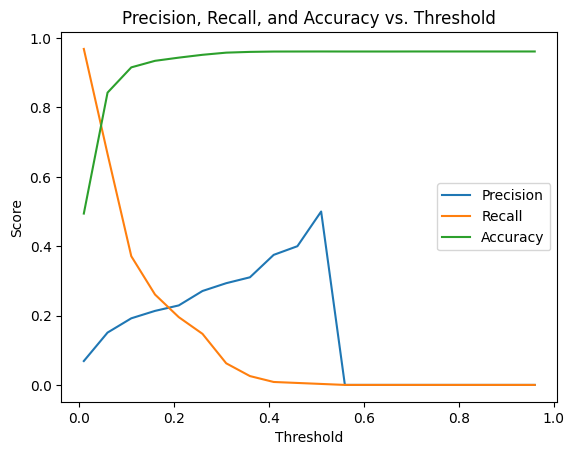

In [103]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()

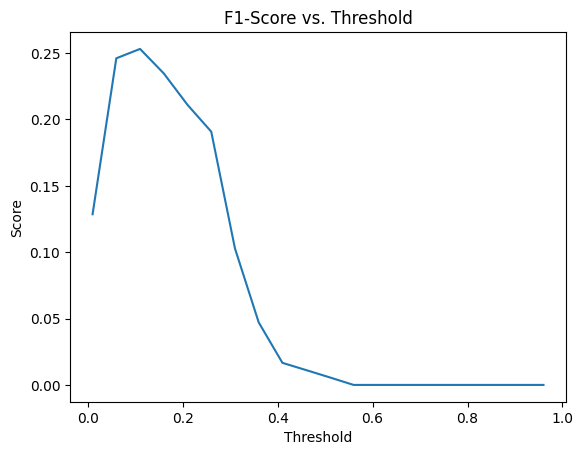

In [104]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score vs. Threshold')
plt.show()